In [163]:
import re
from nltk.corpus import stopwords
from scipy import sparse
import numpy as np

stop_words= stopwords.words('english')
# stop_words.extend(
#         ['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get',
#          'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot',
#          'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come',
#          'aci'])

texts = open('corpus.txt', 'r')
texts = texts.readlines()
texts
# text = ''.join([words for words in text])

['The future king is the prince\n',
 'Daughter is the princess\n',
 'Son is the prince\n',
 'Only a man can be a king\n',
 'Only a woman can be a queen\n',
 'The princess will be a queen\n',
 'Queen and king rule the realm\n',
 'The prince is a strong man\n',
 'The princess is a beautiful woman\n',
 'The royal family is the king and queen and their children\n',
 'Prince is only a boy now\n',
 'A boy will be a man']

In [78]:
def clean_text(
        string: str,
        punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
        stop_words=stopwords.words('english')
) -> str:
    string = re.sub(r'https?://\S+|www\.\S+', '', string)
    string = re.sub(r'<.*?>', '', string)

    for x in string.lower():
        if x in punctuations:
            string = string.replace(x, "")

    string = string.lower()
    string = ' '.join([word for word in string.split() if word not in stop_words])

    string = re.sub(r'\s+', ' ', string).strip()
    string = string.split()
    return string

In [165]:
window = 2
word_lists = []
all_text = []

for text in texts:
    text = clean_text(text)
    all_text += text
    for i, word in enumerate(text):
        for w in range(window):
            if i+1+w < len(text):
                word_lists.append([word]+[text[(i+1+w)]])
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])
            # print(i,word)
word_lists


[['future', 'king'],
 ['future', 'prince'],
 ['king', 'prince'],
 ['king', 'future'],
 ['prince', 'king'],
 ['prince', 'future'],
 ['daughter', 'princess'],
 ['princess', 'daughter'],
 ['son', 'prince'],
 ['prince', 'son'],
 ['man', 'king'],
 ['king', 'man'],
 ['woman', 'queen'],
 ['queen', 'woman'],
 ['princess', 'queen'],
 ['queen', 'princess'],
 ['queen', 'king'],
 ['queen', 'rule'],
 ['king', 'rule'],
 ['king', 'queen'],
 ['king', 'realm'],
 ['rule', 'realm'],
 ['rule', 'king'],
 ['rule', 'queen'],
 ['realm', 'rule'],
 ['realm', 'king'],
 ['prince', 'strong'],
 ['prince', 'man'],
 ['strong', 'man'],
 ['strong', 'prince'],
 ['man', 'strong'],
 ['man', 'prince'],
 ['princess', 'beautiful'],
 ['princess', 'woman'],
 ['beautiful', 'woman'],
 ['beautiful', 'princess'],
 ['woman', 'beautiful'],
 ['woman', 'princess'],
 ['royal', 'family'],
 ['royal', 'king'],
 ['family', 'king'],
 ['family', 'royal'],
 ['family', 'queen'],
 ['king', 'queen'],
 ['king', 'family'],
 ['king', 'children'],
 

In [107]:
def create_unique_word_dict(text:list) -> dict:
    """

    :param text:
    :return:
    """
    words = list(set(text))

    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({word:i})

    return unique_word_dict
unique_word_dict = create_unique_word_dict(all_text)

# def create_one_hot_vectors(unique_words:dict)

In [124]:
# One-hot-encoding
n_words = len(unique_word_dict)
words = list(unique_word_dict.keys())

X = []
Y = []

for word_pair in word_lists:
    X.append((word_pair[0] == np.array(words))*1)
    Y.append((word_pair[1] == np.array(words))*1)
X = np.asarray(X)
Y = np.asarray(X)

In [127]:
X.shape
Y.shape

(56, 17)

In [136]:
from tensorflow import keras
from keras import Input
from keras.models import Model
from keras.layers import Dense
# import tensorflow as tf

embed_size = 2
X.shape[1]
inp = Input(shape=X.shape[1],)
inp_layer = Dense(embed_size, activation='linear',)(inp)
hidden_layer = Dense(units=Y.shape[1], activation='softmax')(inp_layer)

model = Model(inputs=inp, outputs=hidden_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.fit(x=X, y=Y, batch_size=256, epochs=1000)


Epoch 1/1000
1/1 [==============================] - 0s 255ms/step - loss: 2.9156
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.9137
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.9118
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.9100
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.9081
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.9062
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.9044
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.9025
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.9007
Epoch 10/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.8988
Epoch 11/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.8970
Epoch 12/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.8951
Epoch 13/1000
1/1 [============================

In [144]:
weights = model.get_weights()[0]
embedding_dict = {}
for word in words:
    embedding_dict.update({word:weights[unique_word_dict[word]]})

In [145]:
embedding_dict

{'rule': array([ 1.3511293, -1.5719585], dtype=float32),
 'daughter': array([-0.42919812, -1.1395935 ], dtype=float32),
 'royal': array([-1.0391058,  1.1546292], dtype=float32),
 'beautiful': array([ 1.0651436 , -0.03102572], dtype=float32),
 'future': array([-1.2741997, -1.2132818], dtype=float32),
 'children': array([1.1938915, 1.1777687], dtype=float32),
 'boy': array([1.0412462, 1.402667 ], dtype=float32),
 'king': array([-1.3882995, -0.1082501], dtype=float32),
 'son': array([0.27890188, 1.076403  ], dtype=float32),
 'realm': array([ 1.1918607, -1.4442744], dtype=float32),
 'queen': array([-0.2970982,  1.2439268], dtype=float32),
 'family': array([-1.4650733,  1.4016684], dtype=float32),
 'prince': array([-0.2703186, -1.7200298], dtype=float32),
 'woman': array([1.3627009, 0.1245331], dtype=float32),
 'princess': array([ 1.4020379, -1.6195999], dtype=float32),
 'man': array([1.050963  , 0.80616176], dtype=float32),
 'strong': array([-1.4185901, -1.5814571], dtype=float32)}

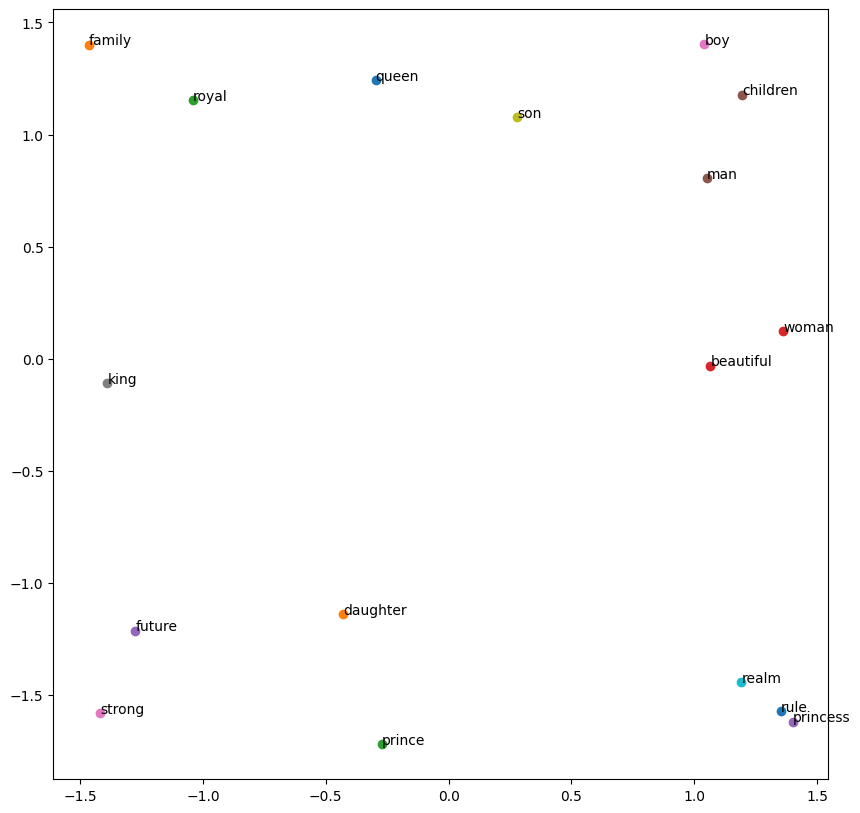

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict[word]
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))

In [226]:
import pandas as pd

invoice_data = pd.read_csv('./input/invoice_data_2.csv')
invoice_data[['SalesQTY']] = invoice_data[['SalesQTY']].astype(int)
unique_product_dict =invoice_data[['ProductCode','ProductName']].drop_duplicates().set_index('ProductName').to_dict()['ProductCode']

products = invoice_data.loc[invoice_data.index.repeat(invoice_data['SalesQTY'])].groupby('Invoiceno')['ProductCode'].apply(list)
products_name = invoice_data.loc[invoice_data.index.repeat(invoice_data['SalesQTY'])].groupby('Invoiceno')['ProductName'].apply(list)
product_corpus = pd.concat([products, products_name], axis=1)

# window = 2

# table = invoice_data.groupby(['Invoiceno', 'ProductCode'])['SalesQTY'].apply(list)
# invoice_data.groupby(['Invoiceno', 'ProductCode'])['SalesQTY'].apply(list)
# invoice_data.groupby('Invoiceno')['ProductCode'].apply(list)

# invoice_data.groupby('Invoiceno')['ProductName'].apply(list)
# invoice = invoice_data[]
# invoice_data.loc[invoice_data["Invoiceno"]==invoice]
# x = []
# for invoice in invoice_data['Invoiceno'].unique():
#     x.append(invoice_data.loc[invoice_data["Invoiceno"]==invoice]['ProductCode'])

In [227]:
product_corpus

,ProductCode,ProductName
Invoiceno,,
D0071103230271,"[2800294, 2700815, 2500002, 2500002, 2400365, ...","[Meridian Real Thai Chicken Chips 18(±3)g, Pro..."
D0071103230301,"[2801390, 2600241, 2802211, 2802211, 2801004, ...","[Azad Pan Pasanda Special 100 gm, Fire Box (12..."
D0071103240075,"[2801402, 2800525, 2800525, 2803115, 2803115, ...","[Aftab Crispy Chicken Wings 500 gm, Harvest Ri..."
D0071103240146,"[2802937, 2803123, 2803123, 2803093, 2803121, ...","[Cadbury Dairy Milk 49±4g(uk), Knorr Chicken ..."
D0071103250232,"[2500066, 2500066, 2500066, 2500066, 2500002, ...","[Milk Vita Liquid Milk 500 Ml, Milk Vita Liqui..."
...,...,...
D0072209191015,"[2816455, 2816455, 2815277, 2815277, 2815277, ...","[Fresh Healthy Choice Salted Biscuit 100g, Fre..."
D0072209191029,"[2500902, 2816053, 2603361, 2603361, 2603361, ...","[Aarong Laban 500ml, Mama Ins.Cup Noodles Spic..."
D0072209191033,"[3000680, 3000382, 3017647, 3811722]","[CloseUp Ever Fresh Menthol Fresh 100g, B.dhar..."


In [219]:
products_name

Invoiceno
D0071103230204                           [Johnson Baby Powder 200g]
D0071103250120          [X-Farlin Wet Wipes (10 PCs)  DT - 004A(B)]
D0071103260132    [Johnson Milk+Rice Baby Bath 200ml MY, Meril B...
D0071103260462             [Angel Feeding Bottle 240 ml RXA-8A2 PP]
D0071103270022          [X-Farlin Wet Wipes (35 PCs)  DT - 005B(B)]
                                        ...                        
D0072209190778                   [Freshmaker Baby Wet Wipes 120Pcs]
D0072209190929    [Kodomo Baby Shampoo Gentle Soft 200ml, Dr. C....
D0072209190950                    [Pepsodent Orange Toothpaste 45g]
D0072209190971                [Parachute Just For Baby Powder 200g]
D0072209191020                            [Savlon Baby Wipes 60Pcs]
Name: ProductName, Length: 53681, dtype: object

Invoiceno
D0071103230204                               [2100108]
D0071103250120                               [2100410]
D0071103260132                      [2100081, 2100110]
D0071103260462                               [2100227]
D0071103270022                               [2100414]
                                  ...                 
D0072209190778                               [2101922]
D0072209190929    [2101457, 2102155, 2100705, 2101284]
D0072209190950                               [2102234]
D0072209190971                               [2102084]
D0072209191020                               [2101954]
Name: ProductCode, Length: 53681, dtype: object